 38%|████████████████████████████▌                                                750/2000 [ETA: 05:37, Elapsed: 03:22]


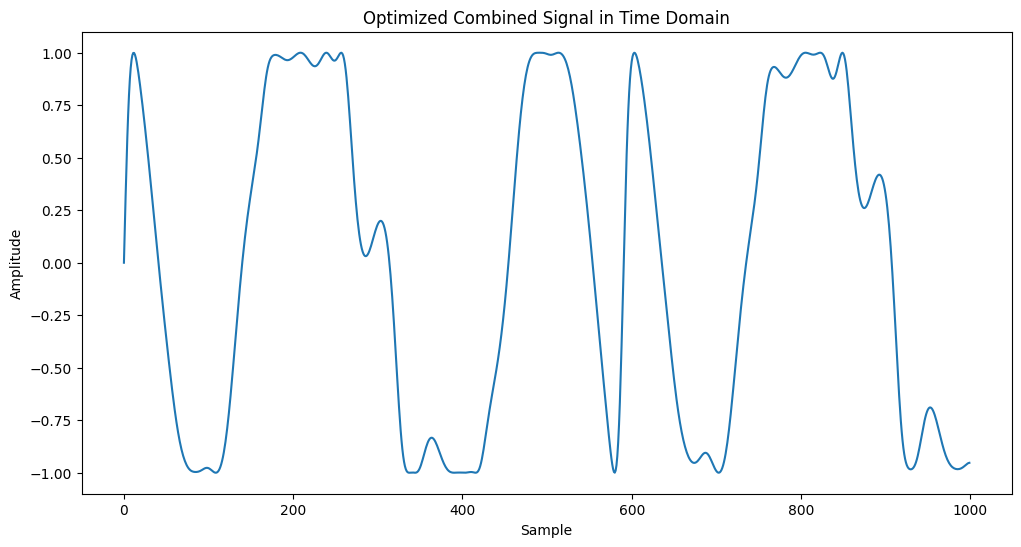

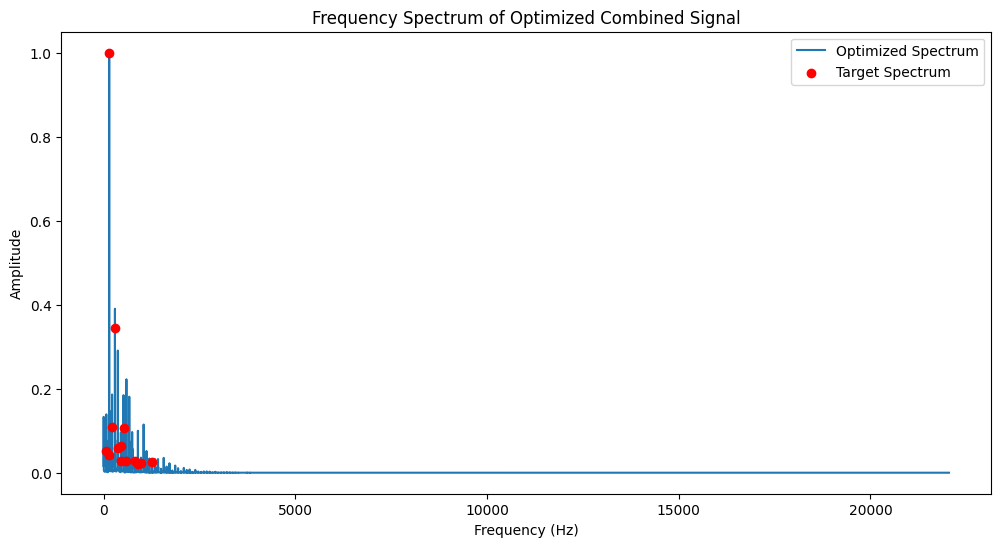

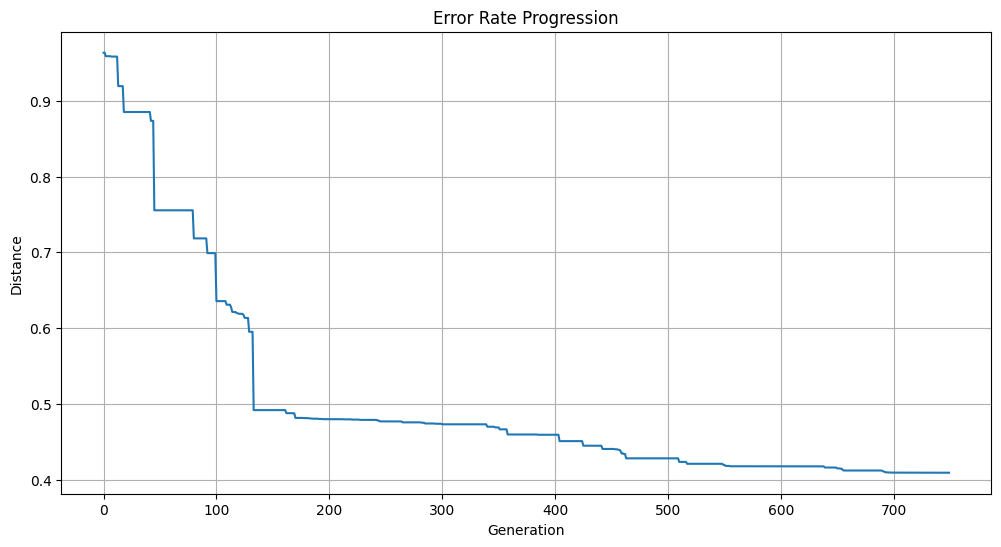

Modulator 4:

    Frequency: 524.0009841221483
    Amplitude: 0.6625926112097063

Modulator 3:

    Frequency: 224.53753423521442
    Amplitude: 0.6239979382781143

Modulator 2:

    Frequency: 74.86544510536424
    Amplitude: 2.1393694578583964

Modulator 1:

    Frequency: 221.8702285551884
    Amplitude: 10.56655062686425

[2024-08-27 00:27:30] 16-bit wave file with 44.1kHz sampling rate saved successfully to: C:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\optimize_fm_beta\rendered_audio\optimized_output_fm_cellotest_differential_evolution.wav


In [18]:
import numpy as np
from IPython.display import Audio, display
from generate_wave_file import generate_wave_file
from fm_synthesis2 import sine_wave, fm_modulate, compute_mfcc, compute_objective
from optimization_utils import load_data, generate_target_mfcc, define_objective_function, run_optimization
from optimization_utils import plot_time_domain_signal, plot_frequency_domain_signal, plot_error_history
import os

# Load data
file_path = 'tsv/cello_single.tsv'
frequencies, amplitudes = load_data(file_path)

# Parameters
duration = 1  # seconds
sample_rate = 44100  # samples per second

# Compute target MFCC mean
target_mfcc_mean = generate_target_mfcc(frequencies, amplitudes, duration, sample_rate, sine_wave, compute_mfcc)

# Define objective function
# Available methods: kullback_leibler_divergence, itakura_saito, spectral_convergence, cosine_similarity, 
# euclidean_distance, manhattan_distance, pearson_correlation_coefficient, mfcc_distance
objective_type = 'cosine_similarity'  # Change this to desired objective type
objective_function = define_objective_function(objective_type, target_mfcc_mean, compute_objective)

# Optimization constraints
bounds = [
    (1, 5000),  # Frequency bounds for osc4
    (0, 12),  # Amplitude bounds for osc4
    (1, 5000),  # Frequency bounds for osc3
    (0, 12),  # Amplitude bounds for osc3
    (1, 5000),  # Frequency bounds for osc2
    (0, 12),  # Amplitude bounds for osc2
    (1, 5000),  # Frequency bounds for osc1
    (0, 12)   # Amplitude bounds for osc1
]

# Select optimization method
optimization_method = 'differential_evolution'  # Options: 'differential_evolution', 'dual_annealing', 'basinhopping'
n_generations = 2000  # Adjusted for faster convergence

# Run optimization
result, error_history = run_optimization(optimization_method, bounds, objective_function, frequencies, amplitudes, duration, sample_rate, n_generations)

# Extract optimal parameters
optimal_params = result.x
optimal_frequencies = optimal_params[0::2]
optimal_amplitudes = optimal_params[1::2]

# Generate combined signal using optimal parameters
mod4 = sine_wave(optimal_frequencies[0], optimal_amplitudes[0], duration, sample_rate)
mod3 = fm_modulate(optimal_frequencies[1], optimal_amplitudes[1], mod4, duration, sample_rate)
mod2 = fm_modulate(optimal_frequencies[2], optimal_amplitudes[2], mod3, duration, sample_rate)
combined_signal = fm_modulate(optimal_frequencies[3], optimal_amplitudes[3], mod2, duration, sample_rate)

# Normalize combined signal
max_val = np.max(np.abs(combined_signal))
if max_val > 0:
    combined_signal /= max_val

# Compute FFT for plotting
fft_result = np.fft.fft(combined_signal)
fft_freqs = np.fft.fftfreq(len(fft_result), 1/sample_rate)
fft_result_np = np.abs(fft_result)
fft_result_np /= np.max(fft_result_np)

# Plotting
plot_time_domain_signal(combined_signal)
plot_frequency_domain_signal(fft_freqs, fft_result_np, frequencies, amplitudes)
plot_error_history(error_history)

# Print optimal parameters in the specified format
for i, (freq, amp) in enumerate(zip(optimal_frequencies, optimal_amplitudes)):
    print(f"Modulator {4-i}:\n")
    print(f"    Frequency: {freq}")
    print(f"    Amplitude: {amp}\n")

# Synthesize and save the audio using the provided script
output_filename = f'optimized_output_fm_cellotest_{optimization_method}.wav'
generate_wave_file(combined_signal, sample_rate, fs_target_name='44.1kHz', custom_filename=output_filename, save_to_file=True)

output_path = os.path.join('rendered_audio', output_filename)
display(Audio(filename=output_path))


In [20]:
# Set new desired duration
new_duration = 30.0  # Set the desired duration in seconds

# Resynthesize the sound using the optimal parameters for the new duration
mod4_new = sine_wave(optimal_frequencies[0], optimal_amplitudes[0], new_duration, sample_rate)
mod3_new = fm_modulate(optimal_frequencies[1], optimal_amplitudes[1], mod4_new, new_duration, sample_rate)
mod2_new = fm_modulate(optimal_frequencies[2], optimal_amplitudes[2], mod3_new, new_duration, sample_rate)
combined_signal_new = fm_modulate(optimal_frequencies[3], optimal_amplitudes[3], mod2_new, new_duration, sample_rate)

# Normalize the resynthesized signal
max_val_new = np.max(np.abs(combined_signal_new))
if max_val_new > 0:
    combined_signal_new /= max_val_new

# Synthesize and save the new audio file
output_filename_new = 'optimized_output_fm_resynthesized.wav'
generate_wave_file(combined_signal_new, sample_rate, fs_target_name='44.1kHz', custom_filename=output_filename_new, save_to_file=True)

# Display the new audio
output_path_new = os.path.join('rendered_audio', output_filename_new)
display(Audio(filename=output_path_new))

[2024-08-27 00:28:00] 16-bit wave file with 44.1kHz sampling rate saved successfully to: C:\Users\egorp\Nextcloud\code\public_repos\FFTimbre\optimize_fm_beta\rendered_audio\optimized_output_fm_resynthesized.wav


In [9]:
from evaluation_metrics import evaluate_fit

# # Consider only the positive part of the FFT
# fft_freqs = fft_freqs[:len(fft_freqs)//2]
# fft_result_np = fft_result_np[:len(fft_result_np)//2]

# Evaluate the fit between the target and optimized spectra
evaluate_fit(frequencies, amplitudes, fft_freqs, fft_result_np)  # Compare the target spectrum with the optimized spectrum

Mean Squared Error (MSE): 0.03293441973980348
Root Mean Squared Error (RMSE): 0.1814784277532828
Mean Absolute Error (MAE): 0.09293979877440676
Cosine Similarity: 0.5161657134766929
Pearson Correlation Coefficient: 0.07963986571139815
Spectral Convergence: 0.9999999188373508


In [4]:
len(fft_freqs)

3750